# Exploration of Nearby Venues

In [1]:
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize
import json
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
# Import BeautifulSoup
!pip install bs4
from bs4 import BeautifulSoup #for wrangling HTML content as per requirements
import warnings
warnings.filterwarnings('ignore')
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
CLIENT_ID = 'GRKV4JNN34PXDKU5HJOAC21E4NUMLIXMVKAKYYP5S2LCSWNY' # your Foursquare ID
CLIENT_SECRET = 'HH0VCRAZKLUI5DYSNNQP4ZU1FR52NHGTKDKV4OF5LMAGVOXZ' # your Foursquare Secret
VERSION = '20180604'
limit = 200
radius = 6000

## Read CSV data

In [3]:
prop_df = pd.read_csv('capstone_data/houses_filtered.csv')

In [4]:
prop_df.CITY.unique()

array(['Gaithersburg', 'North Potomac', 'Laytonsville', 'Darnestown',
       'Derwood', 'Rockville', 'Washington Grove', 'Kensington',
       'North Bethesda', 'Potomac', 'Silver Spring'], dtype=object)

### Create a dataframe with cities and coordinates

In [5]:
column_name = ['CITY','LATITUDE','LONGITUDE']
city_df = pd.DataFrame(columns=column_name)
city_df['CITY']=['Gaithersburg', 'North Potomac', 'Laytonsville', 'Darnestown',
       'Derwood', 'Rockville', 'Washington Grove', 'Kensington',
       'North Bethesda', 'Potomac', 'Silver Spring']
print("Shape of dataframe:",city_df.shape)
city_df.head()

Shape of dataframe: (11, 3)


,CITY,LATITUDE,LONGITUDE
0,Gaithersburg,NaN,NaN
1,North Potomac,NaN,NaN
2,Laytonsville,NaN,NaN
3,Darnestown,NaN,NaN
4,Derwood,NaN,NaN


### Populate the coordinates

In [6]:
for i in range(0,len(city_df)):
    loc = str(city_df['CITY'][i]+', MD')
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(loc)
    longitude = location.longitude
    latitude = location.latitude
    city_df['LATITUDE'][i]=latitude
    city_df['LONGITUDE'][i]=longitude

city_df.head()

,CITY,LATITUDE,LONGITUDE
0,Gaithersburg,39.1434,-77.2014
1,North Potomac,39.098,-77.2369
2,Laytonsville,39.2088,-77.1413
3,Darnestown,39.1034,-77.2908
4,Derwood,39.1173,-77.1611


## Get nearby venues

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
venues = getNearbyVenues(names=city_df['CITY'],
                         latitudes=city_df['LATITUDE'],
                         longitudes=city_df['LONGITUDE'], 
                         radius=radius)

Gaithersburg
North Potomac
Laytonsville
Darnestown
Derwood
Rockville
Washington Grove
Kensington
North Bethesda
Potomac
Silver Spring


In [9]:
print(venues.shape)
venues.head(10)

(1051, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gaithersburg,39.143441,-77.20137,Sardi's Pollo a la Brasa,39.147017,-77.205992,Latin American Restaurant
1,Gaithersburg,39.143441,-77.20137,La Casita Pupuseria & Cocina C.A.,39.142039,-77.198903,Latin American Restaurant
2,Gaithersburg,39.143441,-77.20137,Old Town Cafe,39.142541,-77.193474,Café
3,Gaithersburg,39.143441,-77.20137,Bohrer Park,39.132643,-77.193522,Park
4,Gaithersburg,39.143441,-77.20137,Tortacos,39.153013,-77.197087,Taco Place
5,Gaithersburg,39.143441,-77.20137,Ixtapalapa Taqueria,39.146487,-77.204229,Taco Place
6,Gaithersburg,39.143441,-77.20137,The Vitamin Shoppe,39.144836,-77.203069,Supplement Shop
7,Gaithersburg,39.143441,-77.20137,ProFIT Club,39.142379,-77.193276,Gym / Fitness Center
8,Gaithersburg,39.143441,-77.20137,Dogfish Head Alehouse,39.141832,-77.217272,Bar
9,Gaithersburg,39.143441,-77.20137,99 Ranch Market,39.149857,-77.205941,Supermarket


### Let's check how many venues were returned for each neighborhood.

In [10]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Darnestown,100,100,100,100,100,100
Derwood,100,100,100,100,100,100
Gaithersburg,100,100,100,100,100,100
Kensington,100,100,100,100,100,100
Laytonsville,52,52,52,52,52,52
North Bethesda,100,100,100,100,100,100
North Potomac,100,100,100,100,100,100
Potomac,99,99,99,99,99,99
Rockville,100,100,100,100,100,100


In [11]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 175 uniques categories.


In [12]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Yoga Studio,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,...,Toy / Game Store,Trail,Veterinarian,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
onehot.shape

(1051, 175)

### Let's group by neighborhood and by taking the mean of the frequency of occurance of each category.

In [14]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Yoga Studio,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Toy / Game Store,Trail,Veterinarian,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Darnestown,0.010000,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.000000,0.00,...,0.00,0.040000,0.00,0.010000,0.02,0.00,0.01,0.000000,0.00,0.000000
1,Derwood,0.000000,0.000000,0.000000,0.030000,0.00,0.000000,0.00,0.010000,0.01,...,0.01,0.000000,0.01,0.000000,0.01,0.00,0.00,0.010000,0.01,0.000000
2,Gaithersburg,0.000000,0.000000,0.000000,0.050000,0.00,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.01,0.000000,0.00,0.00,0.00,0.020000,0.01,0.000000
3,Kensington,0.010000,0.000000,0.000000,0.020000,0.01,0.000000,0.00,0.000000,0.01,...,0.00,0.040000,0.00,0.000000,0.04,0.01,0.00,0.000000,0.00,0.000000
4,Laytonsville,0.000000,0.019231,0.019231,0.000000,0.00,0.000000,0.00,0.019231,0.00,...,0.00,0.038462,0.00,0.038462,0.00,0.00,0.00,0.038462,0.00,0.000000
5,North Bethesda,0.000000,0.000000,0.000000,0.050000,0.00,0.000000,0.01,0.010000,0.02,...,0.00,0.020000,0.00,0.000000,0.01,0.00,0.01,0.000000,0.00,0.010000
6,North Potomac,0.010000,0.000000,0.000000,0.040000,0.00,0.010000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.000000,0.01,0.00,0.00,0.020000,0.01,0.000000
7,Potomac,0.010101,0.000000,0.000000,0.040404,0.00,0.010101,0.00,0.000000,0.00,...,0.00,0.090909,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.010101
8,Rockville,0.000000,0.000000,0.000000,0.030000,0.00,0.000000,0.01,0.000000,0.02,...,0.00,0.000000,0.01,0.000000,0.00,0.00,0.01,0.000000,0.01,0.000000
9,Silver Spring,0.010000,0.000000,0.000000,0.040000,0.00,0.000000,0.00,0.010000,0.00,...,0.01,0.040000,0.00,0.000000,0.03,0.01,0.00,0.000000,0.00,0.000000


### Let's print each neighborhood along with top 5 most common venues

In [15]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Darnestown----
                  venue  freq
0           Pizza Place  0.06
1         Grocery Store  0.05
2  Fast Food Restaurant  0.04
3    Chinese Restaurant  0.04
4           Coffee Shop  0.04


----Derwood----
                  venue  freq
0  Gym / Fitness Center  0.05
1                  Park  0.04
2           Pizza Place  0.04
3            Donut Shop  0.03
4   American Restaurant  0.03


----Gaithersburg----
                 venue  freq
0          Pizza Place  0.06
1   Mexican Restaurant  0.06
2  American Restaurant  0.05
3                  Bar  0.03
4                 Café  0.03


----Kensington----
                   venue  freq
0            Pizza Place  0.05
1                   Park  0.05
2  Vietnamese Restaurant  0.04
3                  Trail  0.04
4   Gym / Fitness Center  0.03


----Laytonsville----
                venue  freq
0         Golf Course  0.06
1                Park  0.06
2                Farm  0.06
3  Mexican Restaurant  0.06
4         Video Store  0.04


----No

### Let's put that into a pandas dataframe

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [17]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Darnestown,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
1,Derwood,Gym / Fitness Center,Pizza Place,Park,Donut Shop,Chinese Restaurant,American Restaurant,Mexican Restaurant,Hotel,Ice Cream Shop,Coffee Shop
2,Gaithersburg,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
3,Kensington,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
4,Laytonsville,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
5,North Bethesda,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Supermarket,Cosmetics Shop,New American Restaurant
6,North Potomac,Pizza Place,Mexican Restaurant,Sushi Restaurant,American Restaurant,Coffee Shop,Bar,Sandwich Place,Gym,Grocery Store,Seafood Restaurant
7,Potomac,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
8,Rockville,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
9,Silver Spring,Grocery Store,Latin American Restaurant,American Restaurant,Bakery,Brewery,Coffee Shop,Trail,Mexican Restaurant,Vietnamese Restaurant,Indian Restaurant


______

# Neighborhoods Clusters

In [18]:
max_range = 10

grouped_clustering = grouped.drop('Neighborhood', axis=1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

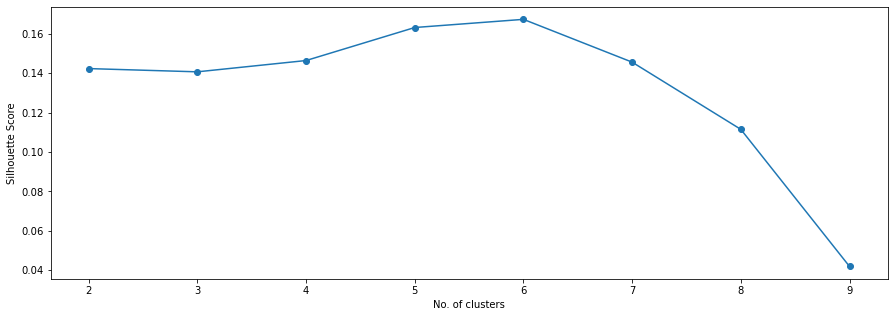

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.savefig('capstone_images/no_clusters.png',dpi=300)
    plt.show()
    
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Run k-means to cluster the neighborhoods into 6 clusters.

In [20]:
# set number of clusters
kclusters = 6

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 5, 4, 1, 2, 3, 1, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gaithersburg,39.143441,-77.20137,Sardi's Pollo a la Brasa,39.147017,-77.205992,Latin American Restaurant,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
1,Gaithersburg,39.143441,-77.20137,La Casita Pupuseria & Cocina C.A.,39.142039,-77.198903,Latin American Restaurant,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
2,Gaithersburg,39.143441,-77.20137,Old Town Cafe,39.142541,-77.193474,Café,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
3,Gaithersburg,39.143441,-77.20137,Bohrer Park,39.132643,-77.193522,Park,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
4,Gaithersburg,39.143441,-77.20137,Tortacos,39.153013,-77.197087,Taco Place,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop


Let's visualize the resulting clusters.

In [22]:
def generateBaseMap(default_location=[39.11733, -77.1610916], default_zoom_start=10.5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [33]:
# create map
map_clusters = generateBaseMap()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Neighborhood Latitude'], merged['Neighborhood Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Let's examine the clusters

### Cluster 1

In [24]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
252,39.103441,-77.253840,Pizza Place,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
253,39.103441,-77.291616,Grocery Store,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
254,39.103441,-77.267962,Farm,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
255,39.103441,-77.250068,Market,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
256,39.103441,-77.291697,Coffee Shop,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,39.103441,-77.314519,Scenic Lookout,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
348,39.103441,-77.248945,Trail,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
349,39.103441,-77.248944,Farm,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant
350,39.103441,-77.273340,Grocery Store,0,Pizza Place,Grocery Store,Coffee Shop,Chinese Restaurant,Trail,Farm,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Restaurant


### Cluster 2

In [25]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
452,39.084005,-77.153057,Deli / Bodega,1,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
453,39.084005,-77.150672,Shopping Plaza,1,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
454,39.084005,-77.153266,Bubble Tea Shop,1,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
455,39.084005,-77.150218,Hotel,1,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
456,39.084005,-77.143439,Gym / Fitness Center,1,Grocery Store,Gym / Fitness Center,American Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Persian Restaurant,Burger Joint,Café,Salad Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,39.046129,-77.145936,Cosmetics Shop,1,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Supermarket,Cosmetics Shop,New American Restaurant
848,39.046129,-77.158043,Gym,1,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Supermarket,Cosmetics Shop,New American Restaurant
849,39.046129,-77.140792,Thai Restaurant,1,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Supermarket,Cosmetics Shop,New American Restaurant
850,39.046129,-77.146109,Shopping Mall,1,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Supermarket,Cosmetics Shop,New American Restaurant


### Cluster 3

In [26]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,39.143441,-77.205992,Latin American Restaurant,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
1,39.143441,-77.198903,Latin American Restaurant,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
2,39.143441,-77.193474,Café,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
3,39.143441,-77.193522,Park,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
4,39.143441,-77.197087,Taco Place,2,Mexican Restaurant,Pizza Place,American Restaurant,Supermarket,Sandwich Place,Café,Coffee Shop,Bar,Gym / Fitness Center,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,39.139830,-77.204135,Chocolate Shop,2,Mexican Restaurant,American Restaurant,Pizza Place,Gym / Fitness Center,Ice Cream Shop,Coffee Shop,Donut Shop,Bar,Supermarket,Park
648,39.139830,-77.206934,Grocery Store,2,Mexican Restaurant,American Restaurant,Pizza Place,Gym / Fitness Center,Ice Cream Shop,Coffee Shop,Donut Shop,Bar,Supermarket,Park
649,39.139830,-77.196246,Mexican Restaurant,2,Mexican Restaurant,American Restaurant,Pizza Place,Gym / Fitness Center,Ice Cream Shop,Coffee Shop,Donut Shop,Bar,Supermarket,Park
650,39.139830,-77.219293,Hotel,2,Mexican Restaurant,American Restaurant,Pizza Place,Gym / Fitness Center,Ice Cream Shop,Coffee Shop,Donut Shop,Bar,Supermarket,Park


### Cluster 4

In [27]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
852,39.017936,-77.211060,Restaurant,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
853,39.017936,-77.209167,Miscellaneous Shop,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
854,39.017936,-77.210538,Burger Joint,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
855,39.017936,-77.209141,Pub,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
856,39.017936,-77.209994,Yoga Studio,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,39.017936,-77.168530,Trail,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
947,39.017936,-77.249251,Outdoor Sculpture,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
948,39.017936,-77.178590,Intersection,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place
949,39.017936,-77.180790,Trail,3,Trail,Golf Course,Bank,Tennis Court,American Restaurant,Coffee Shop,Burger Joint,Pool,Park,Pizza Place


### Cluster 5

In [34]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
200,39.20879,-77.139956,Pizza Place,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
201,39.20879,-77.117286,Golf Course,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
202,39.20879,-77.189259,Liquor Store,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
203,39.20879,-77.171436,Thai Restaurant,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
204,39.20879,-77.188837,Greek Restaurant,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
205,39.20879,-77.171950,Mexican Restaurant,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
206,39.20879,-77.167714,Flower Shop,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
207,39.20879,-77.080256,Brewery,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
208,39.20879,-77.085457,Trail,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery
209,39.20879,-77.160089,Motorcycle Shop,4,Mexican Restaurant,Golf Course,Park,Farm,Wine Shop,Grocery Store,Greek Restaurant,Video Store,Trail,Brewery


### Cluster 6

In [29]:
merged.loc[merged['Cluster Labels'] == 5, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
652,39.025672,-77.074486,Pizza Place,5,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
653,39.025672,-77.076768,Coffee Shop,5,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
654,39.025672,-77.074350,Chinese Restaurant,5,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
655,39.025672,-77.074349,French Restaurant,5,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
656,39.025672,-77.072088,Farmers Market,5,Pizza Place,Park,Vietnamese Restaurant,Trail,Bagel Shop,Farmers Market,Grocery Store,Mexican Restaurant,Gym / Fitness Center,Movie Theater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,38.995946,-77.094378,Department Store,5,Grocery Store,Latin American Restaurant,American Restaurant,Bakery,Brewery,Coffee Shop,Trail,Mexican Restaurant,Vietnamese Restaurant,Indian Restaurant
1047,38.995946,-77.012047,Food Truck,5,Grocery Store,Latin American Restaurant,American Restaurant,Bakery,Brewery,Coffee Shop,Trail,Mexican Restaurant,Vietnamese Restaurant,Indian Restaurant
1048,38.995946,-77.092240,Farmers Market,5,Grocery Store,Latin American Restaurant,American Restaurant,Bakery,Brewery,Coffee Shop,Trail,Mexican Restaurant,Vietnamese Restaurant,Indian Restaurant
1049,38.995946,-77.076398,Grocery Store,5,Grocery Store,Latin American Restaurant,American Restaurant,Bakery,Brewery,Coffee Shop,Trail,Mexican Restaurant,Vietnamese Restaurant,Indian Restaurant
